# Inference of parameters with latent variables (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2          # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SIR_traj.npy', data_array)

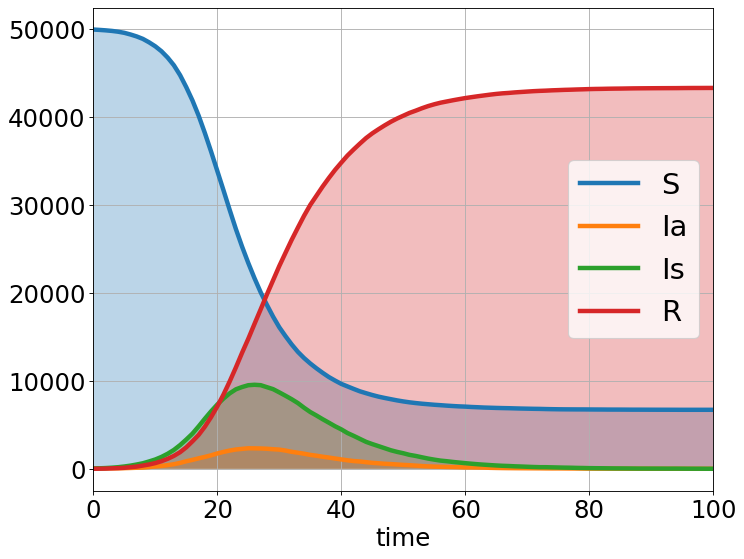

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.fill_between(t, 0, N - np.sum(data_array[:, :], axis=1), alpha=0.3)
plt.plot(t, N - np.sum(data_array[:, :], axis=1), '-', label='R', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the $I_\mathrm{s}$ trajectory and use it to infer the parameters of the model.

In [4]:
# load the data and rescale to intensive variables 
N_start = 5 
Tf_inference = 15
Nf_inference = Tf_inference + 1

x = np.load('latent_SIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]
steps = 5

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

### 2.1) Make a filter for the observed data 
We want a matrix $\boldsymbol{F}$ such that 
$$
\boldsymbol{F}\boldsymbol{x} = \boldsymbol{x}_\mathrm{obs}
$$

In [5]:
# a filter that gives the symptomatic infected
fltr = np.kron([0, 0, 1],np.identity(M))
print(fltr)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]


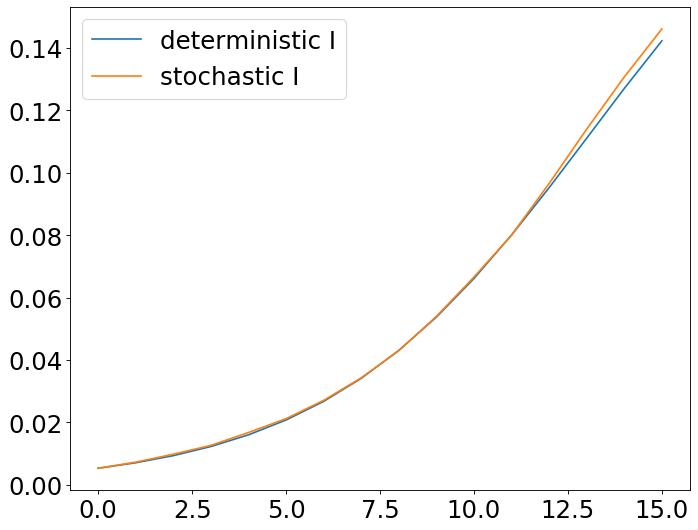

In [6]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)

x0=x[0]

det_model = estimator.make_det_model(parameters)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
det_obs = np.einsum('ij,kj->ki', fltr, xm)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(det_obs, axis=1), label='deterministic I')
plt.plot(np.sum(obs, axis=1), label='stochastic I')
plt.legend()
plt.show()

In [7]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp) 
print(end_time - start_time)

-188.73986578098612
0.14249086380004883


In [8]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4

alpha_g = 0.2 
alpha_std = 0.05
alpha_bounds = (eps, 0.5) 

beta_g = 0.04
beta_std = 0.1
beta_bounds = (eps, 0.4)

gIa_g = 0.13
gIa_std = 0.05
gIa_bounds = (eps, 0.3)

gIs_g = 0.14
gIs_std = 0.05
gIs_bounds = (eps, 0.3) 

Ia0_g = x0[M:2*M]
Ia_std = Ia0_g*5
bounds_for_Ia = np.tile([0.1/N, 1000/N], M).reshape(M, 2)

S0_g = x0[:M]# need the sum of S0_g + I0 (observed in this case) over each age group to be smaller than fi 
S_std = Ia_std
bounds_for_S = np.array([(0.1/N, f-1/N) for f in fi]).reshape(M, 2)

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
keys = ['alpha', 'beta', 'gIa', 'gIs']
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, 
                  *S0_g, *Ia0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, 
                 *S_std, *Ia_std])

# set up fltr for initial conditions because they are constraint by the observed 
init_fltr = np.repeat([True, True, False], M)

estimator.set_det_method('RK2')
estimator.set_lyapunov_method('euler') # use faster methods 
start_time = time.time()
params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=False,
                                    global_max_iter=30, global_atol=1, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=3532146918, Wed Jun 10 13:35:18 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.749269530039393e+03 1.0e+00 9.07e-01  3e-03  9e-02 0:00.3
    2     32 1.445653171506631e+02 1.3e+00 9.11e-01  3e-03  9e-02 0:00.6
    3     48 1.733275569137345e+03 1.4e+00 8.28e-01  3e-03  8e-02 0:00.9
   15    240 -1.973713869220340e+02 3.7e+00 4.25e-01  1e-03  2e-02 0:04.0
Optimal value (global minimisation):  -220.46474665629177
Starting local minimisation...
Optimal value (local minimisation):  -221.48467774156242
10.226255655288696


In [9]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = estimator.fill_params_dict(keys, params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print((x[0]*N).astype('int'))

partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))
print('R initial = ', N*(fi - np.sum(x0.reshape((3, 2)), axis=0)))

logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix, tangent=False)

print('\n log p for best estimates:')
print(logp)

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.21045974934921027, 'beta': 0.021179233731869924, 'gIa': 0.23208498951314452, 'gIs': 0.13881098446642107, 'fsa': array([1., 1.])}

 True initial conditions: 
[12264 37283    42    33   138   126]

 Inferred initial conditons: 
[12235 37230    22    23   138   126]
R initial =  [104.27606474 120.73035327]

 log p for best estimates:
-193.53258325571474


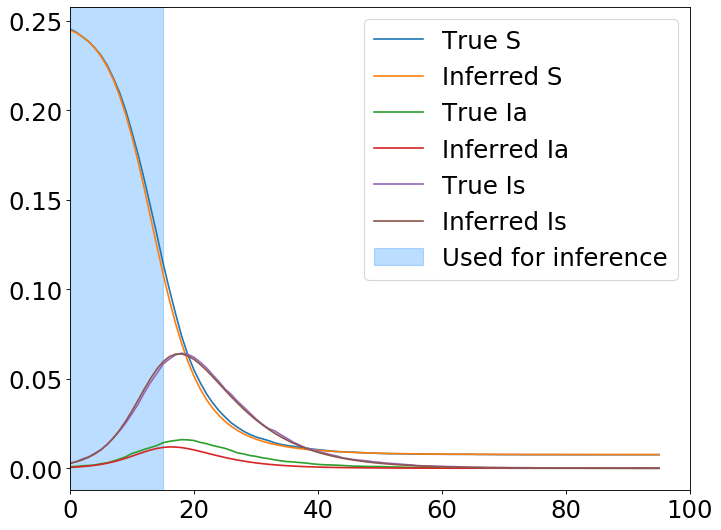

In [10]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model = estimator.make_det_model(best_estimates)
partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, N_start-1, Tf, Nf-N_start, det_model, contactMatrix)
x = np.load('latent_SIR_traj.npy').astype('float')[N_start:]/N 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,0], label='True S')
plt.plot(x_det[:, 0], label='Inferred S')
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

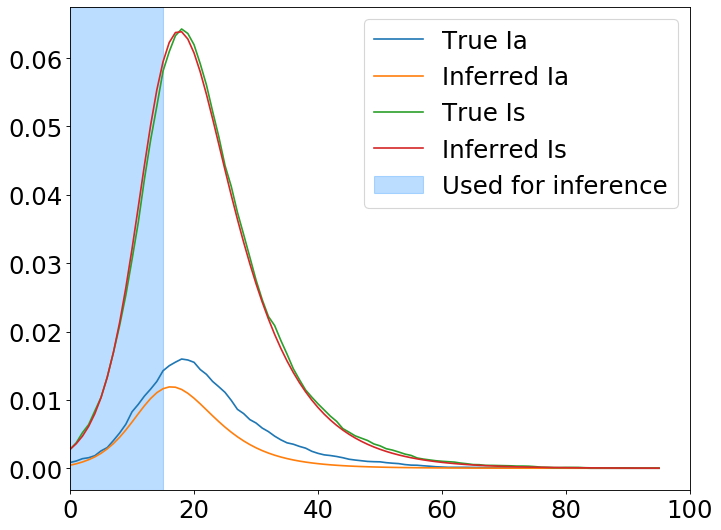

In [11]:
# replot the infected 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()

### Next step (working progress): sample the parameters with nested sampling to get a better prediction. 